<a href="https://colab.research.google.com/github/Minh-A/Dacon/blob/main/Dacon_ScikitLearn_Beta10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

from tqdm import tqdm  # 진행표시바

import xgboost as xgb  # XGBoost 불러오기
from xgboost import plot_importance  # Feature Importance를 불러오기 위함

from sklearn.ensemble import GradientBoostingRegressor  # 그레디언트 부스팅

In [2]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/train.csv')
fn.tail()

,month,file_nm
477,2018-08,201808.npy
478,2018-09,201809.npy
479,2018-10,201810.npy
480,2018-11,201811.npy
481,2018-12,201812.npy


In [5]:
# 132개를 향해
# 200801
dm = fn.iloc[351:,1]
dm.shape

(131,)

In [6]:
# 데이터 생성
data = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/train/200801.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/train/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape

100%|██████████| 131/131 [00:42<00:00,  3.07it/s]


(132, 448, 304)

In [8]:
# 월별 데이터 셋 만들기

# 데이터 셋 형태 변환
data = data.reshape(132,1, 448,304)

# 월별로 데이터 셋 생성
for i in tqdm(range(12)):
  # globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i]), axis=0))
  globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i], data[60+i], data[72+i], data[84+i], data[96+i], data[108+i], data[120+i]), axis=0))

  # globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i], data[60+i], data[72+i], data[84+i], data[96+i], data[108+i], data[120+i],
  #                                                           data[132+i], data[144+i], data[156+i], data[168+i], data[180+i], data[192+i], data[204+i]), axis=0))

  print("\n",globals()['train{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열

100%|██████████| 12/12 [00:00<00:00, 353.75it/s]


 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)

 (11, 448, 304)


In [ ]:
# 월별 이동 데이터 셋 만들기

# 월별로 데이터 셋 생성
for i in tqdm(range(12)):
  a = globals()['train{}'.format(i)]
  globals()['mvtrain{}'.format(i)] = np.array(np.concatenate(((a[1] - a[0]).reshape(1, 448,304), (a[2] - a[1]).reshape(1, 448,304), (a[3] - a[2]).reshape(1, 448,304), (a[4] - a[3]).reshape(1, 448,304),
                                                               (a[5] - a[4]).reshape(1, 448,304), (a[6] - a[5]).reshape(1, 448,304), (a[7] - a[6]).reshape(1, 448,304), (a[8] - a[7]).reshape(1, 448,304),
                                                               (a[9] - a[8]).reshape(1, 448,304), (a[10] - a[9]).reshape(1, 448,304)), axis=0))

  print("\n",globals()['mvtrain{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열


# 함수 사용

In [12]:
def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [13]:
# 소숫점 버리기
def fun(x) : 
  return np.trunc(x)

In [14]:
# 점수 계산

def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

# Scikit Learn 
> https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

> 머신러닝 앙상블 (ensemble) Gradient Boosting
* https://lsjsj92.tistory.com/544?category=853217
* https://wikidocs.net/26289

> 머신러닝 앙상블 (ensemble) RandomForest
* https://lsjsj92.tistory.com/542?category=853217

## 시험용

In [21]:
# 데이터
x_train = train0[:9].reshape(9,-1).T
y_train = train0[9].reshape(1,-1).T
x_test = train0[1:10].reshape(9,-1).T

real = train0[10]

In [22]:
# 데이터 형태 확인
x_test.shape

(136192, 9)

GradientBoost 모델

In [ ]:
# GradientBoost 모델 1
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(criterion='friedman_mse')
model.fit(x_train, y_train)

In [ ]:
# GradientBoost 모델 2
print(model.score(x_train, y_train))

In [ ]:
# GradientBoost 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# GradientBoost 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

RandomForest 모델

In [ ]:
# RandomForest 모델 1
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

In [ ]:
# RandomForest 모델 2
print(model.score(x_train, y_train))

In [ ]:
# RandomForest 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
# 실제는 4.57
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# RandomForest 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

Bayesian Regression 모델

In [ ]:
# Bayesian Regression 모델 1
from sklearn import linear_model

model = linear_model.BayesianRidge()
model.fit(x_train, y_train)

In [ ]:
# Bayesian Regression 모델 2
print(model.score(x_train, y_train))

In [ ]:
# Bayesian Regression 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# Bayesian Regression 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

SGDRegressor 모델

In [ ]:
# SGDRegressor 모델 1
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(loss='huber',learning_rate='optimal')
model.fit(x_train, y_train)

In [ ]:
# SGDRegressor 모델 2
print(model.score(x_train, y_train))

In [ ]:
# SGDRegressor 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# SGDRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

DecisionTreeRegressor 모델

In [ ]:
# DecisionTreeRegressor 모델 1
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(criterion='mse')
model.fit(x_train, y_train)

In [ ]:
# DecisionTreeRegressor 모델 2
print(model.score(x_train, y_train))

In [ ]:
# DecisionTreeRegressor 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
# 실제는 5.77
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# DecisionTreeRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

HuberRegressor 모델

In [ ]:
# HuberRegressor 모델 1
from sklearn.linear_model import HuberRegressor

model = HuberRegressor()
model.fit(x_train, y_train)

In [ ]:
# HuberRegressor 모델 2
print(model.score(x_train, y_train))

In [ ]:
# HuberRegressor 모델 3
pre = model.predict(x_test)
pre

In [ ]:
# 제출물 계산
# 실제는 4.35
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# HuberRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

KNeighborsRegressor 모델

In [ ]:
# KNeighborsRegressor 모델 1
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=2000, weights='distance', p=1, n_jobs=-1)
model.fit(x_train, y_train)

In [ ]:
# KNeighborsRegressor 모델 2
# print(model.score(x_train, y_train))

In [ ]:
# KNeighborsRegressor 모델 3
pre = model.predict(x_test)
pre = pre.reshape(-1)
pre 

In [ ]:
pre = pre / 100
pre

In [ ]:
# 제출물 계산
# 실제는 4.35
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [ ]:
# KNeighborsRegressor 모델 4
show(np.concatenate((real.reshape(1,448,304), np.abs(fun(pre)).reshape(1,448,304))))

In [ ]:
# KNeighborsRegressor 모델 1
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=1500, weights='distance', p=1, n_jobs=-1)  # 1900에 3.59, 1500에 3.58
model.fit(x_train, y_train)

In [ ]:
# KNeighborsRegressor 모델 2
# print(model.score(x_train, y_train))

In [ ]:
# KNeighborsRegressor 모델 3
pre = model.predict(x_test)
pre = pre.reshape(-1)
pre 

In [14]:
# 제출물 계산
# 실제는 4.35
print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

MAE : 2.890705768327068 
 F1 : 0.8097836882287377 
 Final 3.569725810299699


In [ ]:
# 항목 확인
# 배열 내 중복된 원소 제거 후 유일한 원소를 정렬하여 반환
np.unique(np.abs(fun(pre)))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

  0%|          | 0/14 [00:00<?, ?it/s]

1000


  7%|▋         | 1/14 [06:52<1:29:21, 412.41s/it]

MAE : 2.86378788768797 
 F1 : 0.8006562565211068 
 Final 3.5768006914268935
1100


 14%|█▍        | 2/14 [13:54<1:23:02, 415.17s/it]

MAE : 2.8538900963345863 
 F1 : 0.7958762695539336 
 Final 3.5858464055922257
1200


 21%|██▏       | 3/14 [21:10<1:17:16, 421.50s/it]

MAE : 2.844748590225564 
 F1 : 0.7925465647459214 
 Final 3.589377180940499
1300


 29%|██▊       | 4/14 [28:34<1:11:22, 428.27s/it]

MAE : 2.8365836466165413 
 F1 : 0.7897691636655108 
 Final 3.5916616414024705
1400


 36%|███▌      | 5/14 [36:13<1:05:37, 437.54s/it]

MAE : 2.830276374530075 
 F1 : 0.7882082183428847 
 Final 3.590772428854744
1500


 43%|████▎     | 6/14 [44:04<59:40, 447.52s/it]  

MAE : 2.8241746945488724 
 F1 : 0.7871671018023486 
 Final 3.587770185269122
1600


 50%|█████     | 7/14 [52:15<53:43, 460.51s/it]

MAE : 2.817353442199248 
 F1 : 0.7855340430409822 
 Final 3.586545269797824
1700


 57%|█████▋    | 8/14 [1:00:38<47:19, 473.25s/it]

MAE : 2.8134398496240602 
 F1 : 0.7815605644290718 
 Final 3.5997719711991247
1800


 64%|██████▍   | 9/14 [1:09:17<40:35, 487.04s/it]

MAE : 2.80910038768797 
 F1 : 0.7805084553649888 
 Final 3.599064599990407
1900


 71%|███████▏  | 10/14 [1:18:14<33:28, 502.20s/it]

MAE : 2.805164767387218 
 F1 : 0.7792869077822331 
 Final 3.599655920531062
2000


 79%|███████▊  | 11/14 [1:27:29<25:53, 517.83s/it]

MAE : 2.8024773848684212 
 F1 : 0.7775175451780625 
 Final 3.6043911371578155
2100


 86%|████████▌ | 12/14 [1:37:04<17:50, 535.08s/it]

MAE : 2.798850152725564 
 F1 : 0.776119383765195 
 Final 3.60621081654393
2200


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

In [13]:
from sklearn.neighbors import KNeighborsRegressor

num = [680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

  0%|          | 0/12 [00:00<?, ?it/s]

680


  8%|▊         | 1/12 [06:20<1:09:47, 380.70s/it]

MAE : 2.908981437969925 
 F1 : 0.8140421073462444 
 Final 3.5735023728908852
690


 17%|█▋        | 2/12 [12:48<1:03:47, 382.78s/it]

MAE : 2.9070429981203008 
 F1 : 0.8137294068972413 
 Final 3.5724934330196465
700


 25%|██▌       | 3/12 [19:15<57:36, 384.09s/it]  

MAE : 2.9054276315789473 
 F1 : 0.8141308520930446 
 Final 3.568747687699001
710


 33%|███▎      | 4/12 [25:43<51:21, 385.23s/it]

MAE : 2.9037168115601504 
 F1 : 0.8134163296250521 
 Final 3.5697793001043374
720


 42%|████▏     | 5/12 [32:12<45:04, 386.40s/it]

MAE : 2.9019178806390977 
 F1 : 0.8134298160887863 
 Final 3.567508576114532
730


 50%|█████     | 6/12 [38:42<38:44, 387.41s/it]

MAE : 2.900140977443609 
 F1 : 0.8127890418832573 
 Final 3.568134893948058
740


 58%|█████▊    | 7/12 [45:07<32:13, 386.69s/it]

MAE : 2.8985402960526314 
 F1 : 0.8121602386486696 
 Final 3.568926576836813
750


 67%|██████▋   | 8/12 [51:34<25:47, 386.84s/it]

MAE : 2.896807448308271 
 F1 : 0.8113663654695576 
 Final 3.570282841252593
760


 75%|███████▌  | 9/12 [58:04<19:23, 387.91s/it]

MAE : 2.8951553688909772 
 F1 : 0.8105708907710578 
 Final 3.5717484628882588
770


 83%|████████▎ | 10/12 [1:04:34<12:57, 388.54s/it]

MAE : 2.8935400023496243 
 F1 : 0.8104944309925818 
 Final 3.5700923485743044
780


 92%|█████████▏| 11/12 [1:11:06<06:29, 389.60s/it]

MAE : 2.8919319783834587 
 F1 : 0.8108217051382307 
 Final 3.5666681397283932
790


100%|██████████| 12/12 [1:17:39<00:00, 388.27s/it]

MAE : 2.890705768327068 
 F1 : 0.8097836882287377 
 Final 3.569725810299699


In [23]:
from sklearn.neighbors import KNeighborsRegressor

num = [1880, 1890, 1900, 1910, 1920, 1930, 1940]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

  0%|          | 0/7 [00:00<?, ?it/s]

1880


 14%|█▍        | 1/7 [10:31<1:03:08, 631.40s/it]

MAE : 2.8058035714285716 
 F1 : 0.7798981996175258 
 Final 3.597653561487955
1890


 29%|██▊       | 2/7 [20:59<52:32, 630.40s/it]  

MAE : 2.8054951832706765 
 F1 : 0.7798048174405635 
 Final 3.5976889146464157
1900


 43%|████▎     | 3/7 [32:57<43:46, 656.72s/it]

MAE : 2.805164767387218 
 F1 : 0.7792869077822331 
 Final 3.599655920531062
1910


 57%|█████▋    | 4/7 [45:03<33:52, 677.44s/it]

MAE : 2.804768268327068 
 F1 : 0.7792869077822331 
 Final 3.599147123256139
1920


 71%|███████▏  | 5/7 [56:40<22:46, 683.38s/it]

MAE : 2.804437852443609 
 F1 : 0.779452326355538 
 Final 3.5979593897379734
1930


 86%|████████▌ | 6/7 [1:07:11<11:07, 667.75s/it]

MAE : 2.8046214168233083 
 F1 : 0.7793586556550332 
 Final 3.5986273591582996
1940


100%|██████████| 7/7 [1:17:47<00:00, 666.81s/it]

MAE : 2.80418086231203 
 F1 : 0.7794304950040867 
 Final 3.597730451026326


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real.reshape(-1), np.abs(fun(pre))))

  0%|          | 0/11 [00:00<?, ?it/s]

775


  9%|▉         | 1/11 [06:50<1:08:23, 410.30s/it]

MAE : 2.893092105263158 
 F1 : 0.8106580350341042 
 Final 3.568819335088997
776


 18%|█▊        | 2/11 [13:31<1:01:06, 407.44s/it]

MAE : 2.8926662359022557 
 F1 : 0.8108217051382307 
 Final 3.5675737118228357
777


 27%|██▋       | 3/11 [20:23<54:30, 408.84s/it]  

MAE : 2.8924312734962405 
 F1 : 0.8105815641306693 
 Final 3.5683407639734575
778


 36%|███▋      | 4/11 [27:16<47:51, 410.18s/it]

MAE : 2.8924386160714284 
 F1 : 0.8106580350341042 
 Final 3.5680132132035327
779


 45%|████▌     | 5/11 [33:56<40:43, 407.22s/it]

MAE : 2.892343162593985 
 F1 : 0.8106580350341042 
 Final 3.5678954650629593
780


 55%|█████▍    | 6/11 [40:32<33:39, 403.81s/it]

> 최종 점수를 낮추는 방향 고민
* 최적의 n_neighbors를 찾는 것
* 데이터 개수를 조합해 보는 것
* Function 함수를 조정 (현재는 그냥 소숫점을 절삭이니까)

## 메인(1 Data)

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = RandomForestRegressor()
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

In [ ]:
train0.shape

* Dacon 4.57의 결과물

### DecisionTreeRegressor

In [ ]:
for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = DecisionTreeRegressor(criterion='mse')
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

* Dacon 5.77의 결과물

### HuberRegressor

In [ ]:
from sklearn.linear_model import HuberRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = HuberRegressor()
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

In [ ]:
train0.shape

* Dacon 4.35의 결과물

### KNeighborsRegressor

In [9]:
# 확인
train0[:17].shape

(11, 448, 304)

  0%|          | 0/12 [00:00<?, ?it/s]

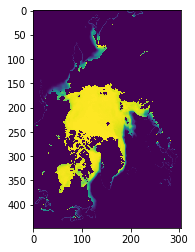

  8%|▊         | 1/12 [07:00<1:17:06, 420.56s/it]

(136192,)


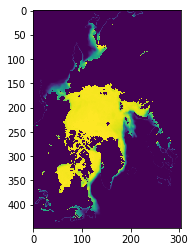

 17%|█▋        | 2/12 [13:53<1:09:41, 418.18s/it]

(136192,)


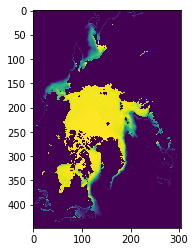

 25%|██▌       | 3/12 [20:50<1:02:42, 418.00s/it]

(136192,)


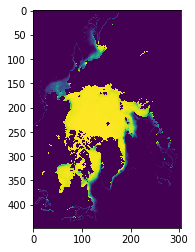

 33%|███▎      | 4/12 [27:57<56:05, 420.70s/it]  

(136192,)


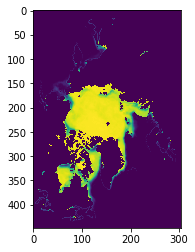

 42%|████▏     | 5/12 [35:20<49:50, 427.20s/it]

(136192,)


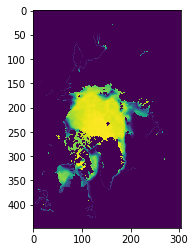

 50%|█████     | 6/12 [42:58<43:39, 436.53s/it]

(136192,)


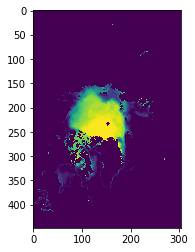

 58%|█████▊    | 7/12 [51:01<37:31, 450.37s/it]

(136192,)


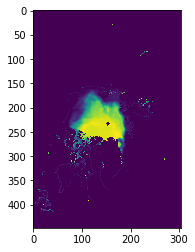

 67%|██████▋   | 8/12 [59:34<31:16, 469.16s/it]

(136192,)


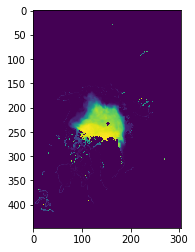

 75%|███████▌  | 9/12 [1:08:13<24:12, 484.21s/it]

(136192,)


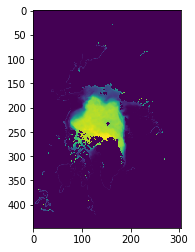

 83%|████████▎ | 10/12 [1:16:38<16:20, 490.37s/it]

(136192,)


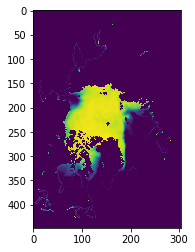

 92%|█████████▏| 11/12 [1:24:35<08:06, 486.46s/it]

(136192,)


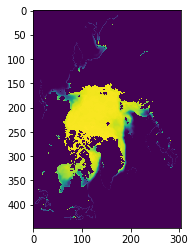

100%|██████████| 12/12 [1:32:30<00:00, 462.55s/it]

(136192,)


In [10]:
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1).T
  y_train = datan[10].reshape(1,-1).T
  x_test = datan[1:11].reshape(10,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=780, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 소숫점은 다 사라져 함수 생성
  # def fun(x) : 
  #   return np.round_(x, 0)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

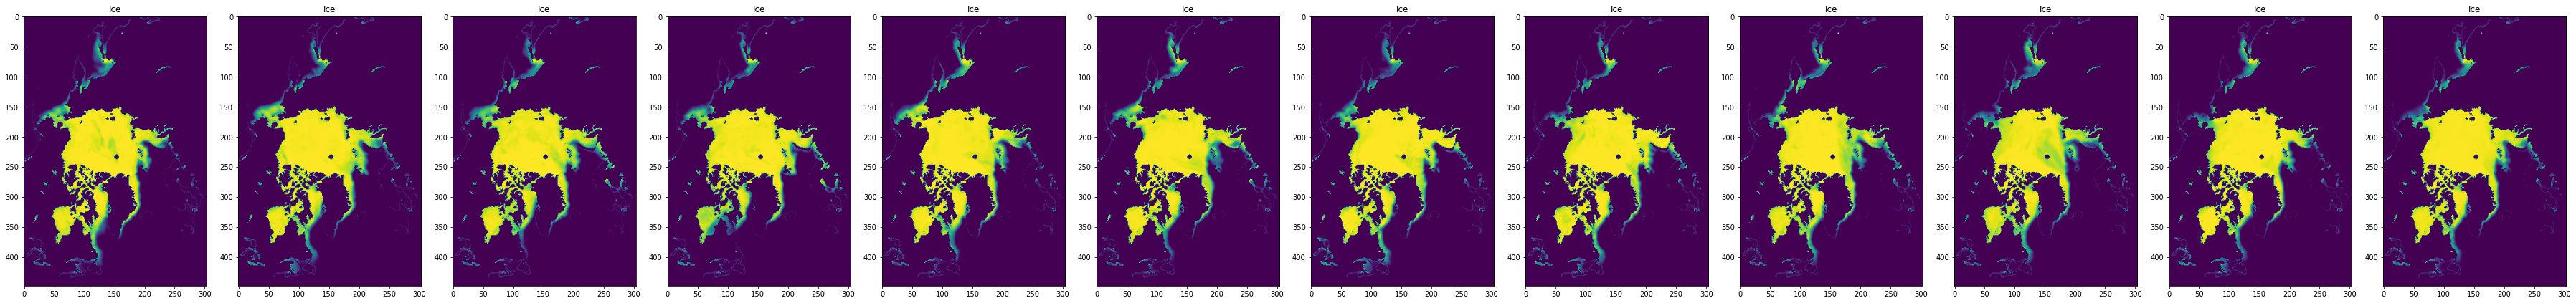

In [20]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

In [ ]:
# 절댓값 추가
np.abs(fun(pred0))

* Dacon 4.09의 결과물 : (n_neighbors=2000, weights='distance', algorithm='brute', p=1)
* Dacon 4.0859의 결과물 : (n_neighbors=1900, weights='distance', p=1, n_jobs=-1)
* Dacon 3.9763의 결과물: (n_neighbors=1000, weights='distance', p=1, n_jobs=-1)
* Dacon 3.9515의 결과물: (n_neighbors=780, weights='distance', p=1, n_jobs=-1)


## 데이터 4등분(4 Data)

#### 시험용

In [ ]:
# 데이터 1개
x_train = train0[:9].reshape(9,-1).T
y_train = train0[9].reshape(1,-1).T
x_test = train0[1:10].reshape(9,-1).T

real = train0[10]

In [ ]:
# 4등분 데이터 셋 생성
for i in range(4):
  print(i)

  globals()['x_train_{}'.format(i)] = train0[:9].reshape(9,-1)[:,34048*i:34048*(i+1)].T
  globals()['y_train_{}'.format(i)] = train0[9].reshape(1,-1)[:,34048*i:34048*(i+1)].T
  globals()['x_test_{}'.format(i)] = train0[1:10].reshape(9,-1)[:,34048*i:34048*(i+1)].T
  globals()['real_{}'.format(i)] = train0[10][112*i:112*(i+1),:304]

  print(globals()['x_train_{}'.format(i)].shape)
  print(globals()['y_train_{}'.format(i)].shape)
  print(globals()['x_test_{}'.format(i)].shape)
  print(globals()['real_{}'.format(i)].shape)

In [ ]:
# 실제 4등분 데이터 확인
import matplotlib.pyplot
matplotlib.pyplot.imshow(real_2, interpolation = 'None')
matplotlib.pyplot.title('자른 데이터 확인')

RandomForest 모델

In [ ]:
# RandomForest 모델 1
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_features='sqrt', n_estimators=600)
model.fit(x_train_2, y_train_2)

In [ ]:
# RandomForest 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# RandomForest 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# RandomForest 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

LARS Lasso 모델

In [ ]:
# LARS Lasso 모델 1
from sklearn import linear_model

model = linear_model.LassoLars(alpha=0.01)
model.fit(x_train_2, y_train_2)

In [ ]:
# LARS Lasso 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# LARS Lasso 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# LARS Lasso 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

DecisonTreeRegressor 모델

In [ ]:
# DecisionTreeRegressor 모델 1
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(criterion='mse')
model.fit(x_train_2, y_train_2)

In [ ]:
# DecisionTreeRegressor 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# DecisionTreeRegressor 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# DecisionTreeRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

HuberRegressor 모델

In [ ]:
# HuberRegressor 모델 1
from sklearn.linear_model import HuberRegressor

model = HuberRegressor()
model.fit(x_train_2, y_train_2)

In [ ]:
# HuberRegressor 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# HuberRegressor 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# HuberRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

SGDRegressor 모델

In [ ]:
# SGDRegressor 모델 1
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(loss='huber',learning_rate='optimal')
model.fit(x_train_2, y_train_2)

In [ ]:
# SGDRegressor 모델 2
print(model.score(x_train_2, y_train_2))

In [ ]:
# SGDRegressor 모델 3
pre = model.predict(x_test_2)
pre

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

In [ ]:
# SGDRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

KNeighborsRegressor 모델

In [ ]:
# KNeighborsRegressor 모델 1
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=1300, weights='distance', algorithm='auto', p=1)  # 1500은 4.13, 2000은 4.17, 1300은 4.11, 1000은 4.13, 500은 4.16, 5000은 5.57
model.fit(x_train_2, y_train_2)

In [ ]:
# KNeighborsRegressor 모델 2
# print(model.score(x_train_2, y_train_2))

In [ ]:
# KNeighborsRegressor 모델 3
pre = model.predict(x_test_2)
pre = pre.reshape(-1)
pre 

In [ ]:
# 제출물 계산
print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

항목의 발생 횟수를 계산
* https://www.delftstack.com/ko/howto/python/how-to-count-the-occurrences-of-an-item-in-a-one-dimensional-array-in-python/

In [ ]:
# 항목 확인
# 배열 내 중복된 원소 제거 후 유일한 원소를 정렬하여 반환
np.unique(np.abs(fun(pre)))

In [ ]:
# KNeighborsRegressor 모델 4
show(np.concatenate((real_2.reshape(1,112,304), np.abs(fun(pre)).reshape(1,112,304))))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

num = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors=i, weights='distance', algorithm='auto', p=1)
  model.fit(x_train_2, y_train_2)

  pre = model.predict(x_test_2)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n F1 : %s' % f1_score(real_2.reshape(-1), np.abs(fun(pre))),
      '\n Final %s' % mae_over_f1(real_2.reshape(-1), np.abs(fun(pre))))

#### KNeighborsRegressor4

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1)
  y_train = datan[10].reshape(1,-1)
  x_test = datan[1:11].reshape(10,-1)

  # 예측 데이터 생성
  predd = []

  # 4등분 데이터 셋 생성
  for j in range(4):
    a = globals()['x_train{}'.format(j)] = x_train[:,34048*j:34048*(j+1)].T
    b = globals()['y_train{}'.format(j)] = y_train[:,34048*j:34048*(j+1)].T
    c = globals()['x_test{}'.format(j)] = x_test[:,34048*j:34048*(j+1)].T

    # 모델 훈련
    model = KNeighborsRegressor(n_neighbors=1200, weights='distance', p=1, n_jobs=-1)
    model.fit(a, b)

    # 모델 예측
    predict = model.predict(c)
    
    predd.append(predict)

  # 완성된 예측 데이터 정제
  predictions = np.array(predd)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 최종 데이터 생성 : 변동성의 합
# mvtrain 데이터를 사용했을때 만 사용

# for i in tqdm(range(12)):
#   ori = globals()['train{}'.format(i)][10].reshape(-1)
#   pr = globals()['pred{}'.format(i)]

#   globals()['mvpred_{}'.format(i)] = ori + pr
#   print(globals()['mvpred_{}'.format(i)].shape)

#   # 그래프를 보자구
#   plt.imshow(globals()['mvpred_{}'.format(i)].reshape(448,304), interpolation = 'None')
#   plt.show()

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0.shape

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

#### KNeighborsRegressor3

In [ ]:
# 데이터셋 나누기 확인
x_train = train0[:10].reshape(10,-1)
x_train[:,:34048].T.shape, x_train[:,34048:102144].T.shape, x_train[:,102144:].T.shape

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[:10].reshape(10,-1)
  y_train = datan[10].reshape(1,-1)
  x_test = datan[1:11].reshape(10,-1)

  # 예측 데이터 생성 (numpy)
  predd = np.array([])

  # 3등분 데이터 셋 생성
  x_train0, x_train1, x_train2 = x_train[:,:34048].T, x_train[:,34048:102144].T, x_train[:,102144:].T
  y_train0, y_train1, y_train2 = y_train[:,:34048].T, y_train[:,34048:102144].T, y_train[:,102144:].T
  x_test0, x_test1, x_test2 = x_test[:,:34048].T, x_test[:,34048:102144].T, x_test[:,102144:].T

  # 3등분의 모델
  for j in tqdm(range(3)):
    a = globals()['x_train{}'.format(j)]
    b = globals()['y_train{}'.format(j)]
    c = globals()['x_test{}'.format(j)]

    # 모델 훈련
    model = KNeighborsRegressor(n_neighbors=1900, weights='distance', p=1, n_jobs=-1)
    model.fit(a, b)

    # 모델 예측
    predict = model.predict(c)
    
    predd = np.append(predd, predict)

  # 완성된 예측 데이터 정제
  predictions = np.array(predd)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
predict.shape

In [ ]:
aaa = np.array([])

np.append(aaa, predict).shape

In [ ]:
predd

In [ ]:
predict.shape

In [ ]:
predictions.shape

In [ ]:
x_train0.shape

In [ ]:
a.shape, b.shape

In [ ]:
model = KNeighborsRegressor(n_neighbors=10, weights='distance', p=1, n_jobs=-1)
model.fit(a, b)

In [ ]:
# 모델 예측
predict = model.predict(c)

In [ ]:
predict.reshape(-1).shape

In [ ]:
np.array(predd).shape

In [ ]:
predictions.shape

In [ ]:
# 원본데이터랑 예측데이터랑 합쳐서
show(np.concatenate((train0, np.abs(fun(pred0)).reshape(1,448,304))))

In [ ]:
# 데이터 확인
pred0

In [ ]:
# 데이터 확인
pred0.reshape(448,304)[250,200], train0[10][250,200]

# 제출

In [15]:
# 제출 형태로 변환

# 데이터 생성
sh1 = pd.DataFrame(pred0.reshape(1,-1))  # 초기값 설정
sh1 = np.abs(fun(sh1))  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred{}'.format(i+1)] = globals()['pred{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred{}'.format(i+1)]
  sh = np.abs(fun(sh))  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh1 = pd.concat((sh1, sh), axis=0)
  print(sh1.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


In [16]:
# 1차 데이터 확인 (Pre-제출본)
sh1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# sh1의 인덱스 수정

# 12개월, 24개월 투투
result = pd.concat([sh1,sh1], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'month'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
19,2020-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2020-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2020-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2020-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2020-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Lets Final Check')

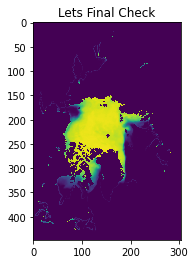

In [18]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [19]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/result/sub_0322_3_KNN.csv', index = False)